In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, AveragePooling2D, \
    Dense, Dropout, Activation, Flatten, BatchNormalization, concatenate, Reshape, Multiply, SpatialDropout2D
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import layers, models
import os
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.preprocessing.image import ImageDataGenerator, DirectoryIterator
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
print(tf.__version__)

2.18.0


In [ ]:
# To use GPU for Google Colab
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
import psutil

ram_gb = psutil.virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

Your runtime has 89.6 gigabytes of available RAM



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.getcwd()

'/content'

In [ ]:
os.listdir()

['.config', 'drive', 'sample_data']

In [ ]:
os.chdir(r'drive/MyDrive/state_dataset')

In [ ]:
#os.chdir(r'C:\Users\mdsou\OneDrive - University of South Florida\USF MS BAIS\CAI 5205 Deep Learning\state_dataset')

In [ ]:
# Set the dataset directories
train_dir = 'train/'
val_dir = 'valid/'
test_dir = 'test/'

In [ ]:
#Define image sizes and number of classes
img_width=299
img_height=299
num_classes=11
batch_size=32 #Should be divided exactly into data set - default

In [ ]:
#Check weight initialization and make sure images are being loaded and labeled correctly.

In [ ]:
#Use image from directory for flow; Uses new image augmentation function
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  seed=42,
  image_size=(img_height, img_width),
  label_mode='categorical',
  #shuffle = True
  )

Found 8578 files belonging to 11 classes.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  val_dir,
  image_size=(img_height, img_width),
  label_mode='categorical',
 #shuffle=False
  )

Found 1907 files belonging to 11 classes.


In [ ]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  #image_size=(img_height, img_width),
  batch_size=1, #Must use batch 1 for testing
  label_mode='categorical',
  shuffle=False
  )

NotFoundError: Could not find directory test/

In [ ]:
#Remove deprecated functions and use tf.layers for data augmentation
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(img_height, img_width, crop_to_aspect_ratio=True),
  #Crop to enforce ratio and preserve image and aspect. Will help with learning accuracy
  layers.Rescaling(1./255)
])

In [ ]:
#Use new layers for data augmentation
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.1),
  layers.RandomZoom(0.1),
  layers.RandomContrast(0.2),
  layers.RandomBrightness(0.2),
  layers.RandomTranslation(0.1, 0.1),
  layers.Lambda(lambda x: tf.clip_by_value(x, 0.0, 1.0))
   #Prevents values above 1 for normalizing with layers
])

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
def prepare(ds, shuffle=False, augment=False):
    def process(x, y):
        x = resize_and_rescale(x)
        if augment:
            x = data_augmentation(x, training=True)
        return x, y

    ds = ds.map(process, num_parallel_calls=AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(1000)

    return ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
# Apply - Will apply and use prefetch calls for dataset
train_ds = prepare(ds=train_ds,
                   shuffle=True,
                   augment=True
                   )
val_ds = prepare(val_ds)
#test_ds = prepare(test_ds)

In [ ]:
for x, y in train_ds.take(1):
    print(x.shape, x.numpy().min(), x.numpy().max())

(32, 299, 299, 3) 0.0 1.0


In [ ]:
from collections import defaultdict

def count_images_per_class(directory):
    count = defaultdict(int)
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            image_files = [
                f for f in os.listdir(class_path)
                if f.lower().endswith(('.jpg', '.jpeg', '.png'))
            ]
            count[class_name] = len(image_files)
    return count

print("Train:", count_images_per_class('train'))

Train: defaultdict(<class 'int'>, {'other': 873, 'jullienne': 607, 'mixed': 675, 'grated': 696, 'peeled': 558, 'whole': 932, 'sliced': 1120, 'juiced': 881, 'floured': 582, 'diced': 898, 'creamy_paste': 756})


In [ ]:
for images, labels in train_ds.take(1):
    print(labels[:5])

tf.Tensor(
[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]], shape=(5, 11), dtype=float32)


In [ ]:
def inception_module(x, filters_1x1, filters_3x3, filters_5x5, pool_proj):
  layer1 = layers.Conv2D(filters_1x1, (1, 1), padding='same', activation='relu',
                         kernel_initializer=kernel_init)(x)

  layer2 = layers.Conv2D((filters_3x3//2), (1, 1), padding='same', activation='relu',
                         kernel_initializer=kernel_init)(x)
  layer2 = layers.Conv2D(filters_3x3, (3, 3), padding='same', activation='relu',
                         kernel_initializer=kernel_init)(layer2)

  layer3 = layers.Conv2D((filters_5x5//2), (1, 1), padding='same', activation='relu',
                         kernel_initializer=kernel_init)(x)
  layer3 = layers.Conv2D(filters_5x5, (5, 5), padding='same', activation='relu',
                         kernel_initializer=kernel_init)(layer3)
  #Inception with dimension reduction
  layer4 = layers.AveragePooling2D((3, 3), strides=(1, 1), padding='same')(x)
  layer4 = layers.Conv2D(pool_proj, (1, 1), padding='same', activation='relu',
                         kernel_initializer=kernel_init)(layer4)

  output = layers.concatenate([layer1, layer2, layer3, layer4], axis=-1)
  output = layers.Activation('relu')(layers.BatchNormalization()(output))

  return output

kernel_init = tf.keras.initializers.HeNormal()

In [ ]:
def inception_module2(x, filters_1x1, filters_3x3, pool_proj):
  layer1 = layers.Conv2D(filters_1x1, (1, 1), padding='same', activation='relu',
                         kernel_initializer=kernel_init)(x)

  layer2 = layers.Conv2D((filters_3x3//2), (1, 1), padding='same', activation='relu',
                         kernel_initializer=kernel_init)(x)
  layer2 = layers.Conv2D(filters_3x3, (3, 3), padding='same', activation='relu',
                         kernel_initializer=kernel_init)(layer2)

  #Inception with dimension reduction
  layer3 = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
  layer3 = layers.Conv2D(pool_proj, (1, 1), padding='same', activation='relu',
                         kernel_initializer=kernel_init)(layer3)

  output = layers.concatenate([layer1, layer2, layer3], axis=-1)
  output = layers.Conv2D(128, (1,1), padding='same')(output)
  output = layers.Activation('relu')(layers.BatchNormalization()(output))

  return output

kernel_init = tf.keras.initializers.HeNormal()

In [ ]:
def ResidualInceptionBlock(x, filters_1x1, filters_3x3, filters_5x5, pool_proj):
    input_channels = x

    inception_out = inception_module(x, filters_1x1, filters_3x3, filters_5x5, pool_proj)

    # Project input if the number of filters differs
    if input_channels.shape[-1] != inception_out.shape[-1]:
        input_channels = layers.Conv2D(inception_out.shape[-1], (1, 1), padding='same')(input_channels)
        input_channels = layers.BatchNormalization()(input_channels)

    x = layers.Add()([input_channels, inception_out])
    x = layers.Activation('relu')(x)
    return x

In [ ]:
def resblock(x, filters, kernelsize = (3,3)):
    input_channel = x

    fx = layers.Conv2D(filters, kernelsize, padding='same', kernel_initializer='he_normal')(x)
    fx = layers.BatchNormalization()(fx)
    fx = layers.Activation('relu')(fx)
    fx = layers.Conv2D(filters, kernelsize, padding='same', kernel_initializer='he_normal')(fx)
    fx = layers.BatchNormalization()(fx)
    fx = layers.Activation('relu')(fx)

    #SE block
    se = layers.GlobalAveragePooling2D()(fx)
    se = layers.Dense(filters // 16, activation='relu')(se)
    se = layers.Dense(filters, activation='sigmoid')(se)
    se = layers.Reshape((1, 1, filters))(se)
    fx = layers.Multiply()([fx, se])

    if input_channel.shape[-1] != filters:
        input_channel = layers.Conv2D(filters, (1,1), padding='same')(input_channel)
        input_channel = layers.BatchNormalization()(input_channel)


    out = layers.Add()([fx, input_channel])
    out = layers.BatchNormalization()(out)
    out = layers.Activation('relu')(out)
    return out

In [ ]:
#CNN with inception modules
#Define input shape at start
input = tf.keras.Input(shape=(img_height, img_width, 3))
#Define layers using same above
x = layers.Conv2D(256, (3, 3), padding='same')(input)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Conv2D(256, (3, 3), padding='same')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

x = inception_module(x, 256, 256, 128, 128)
x = inception_module(x, 128, 128, 64, 64)
#Inception includes BatchNormalization

x = layers.Conv2D(64, (3, 3), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

x = layers.Conv2D(128, (3, 3), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.2)(x)

x = layers.Conv2D(128, (3, 3), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x)

x = layers.Conv2D(128, (3, 3), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

x = layers.GlobalAveragePooling2D()(x)
#May test both for capturing different activations
#avg_pooling = layers.GlobalAveragePooling2D()(x)
#max_pooling = layers.GlobalMaxPooling2D()(x)
#x = layers.Concatenate()([avg_pooling, max_pooling])

#x = layers.Flatten()(x)
x1 = layers.Dense(512)(x)
x1 = layers.BatchNormalization()(x)
x1 = layers.Activation('relu')(x)
x1 = layers.Dense(256, activation='relu')(x)
x1 = layers.Dropout(0.3)(x)

output = layers.Dense(num_classes, activation = 'softmax')(x)

model = models.Model(inputs=input, outputs=output)

model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_54 (Conv2D)  │ (None, 299, 299,  │      7,168 │ input_layer_5[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 299, 299,  │      1,024 │ conv2d_54[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_24       │ (None, 299, 299,  │          0 │ batch_normalizat… │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_55 (Conv2D)  │ (None, 299, 299,  │    590,080 │ activation_24[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_14    │ (None, 149, 149,  │          0 │ conv2d_55[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_57 (Conv2D)  │ (None, 149, 149,  │     65,792 │ max_pooling2d_14… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_59 (Conv2D)  │ (None, 149, 149,  │     32,896 │ max_pooling2d_14… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_15    │ (None, 149, 149,  │          0 │ max_pooling2d_14… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_56 (Conv2D)  │ (None, 149, 149,  │     65,792 │ max_pooling2d_14… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_58 (Conv2D)  │ (None, 149, 149,  │    590,080 │ conv2d_57[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_60 (Conv2D)  │ (None, 149, 149,  │    409,728 │ conv2d_59[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_61 (Conv2D)  │ (None, 149, 149,  │     32,896 │ max_pooling2d_15… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_7       │ (None, 149, 149,  │          0 │ conv2d_56[0][0],  │
│ (Concatenate)       │ 768)              │            │ conv2d_58[0][0],  │
│                     │                   │            │ conv2d_60[0][0],  │
│                     │                   │            │ conv2d_61[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 149, 149,  │      3,072 │ concatenate_7[0]… │
│ (BatchNormalizatio… │ 768)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_25       │ (None, 149, 149,  │          0 │ batch_normalizat… │
│ (Activation)        │ 768)              │            │                 

 Total params: 2,938,891 (11.21 MB)

 Trainable params: 2,935,179 (11.20 MB)

 Non-trainable params: 3,712 (14.50 KB)

In [ ]:
#Use weight decay and higher learning rate
opt = tf.keras.optimizers.Adam(learning_rate=0.0005,
                              weight_decay=0.00003)

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=3, min_lr = 0.0001)
model_save = tf.keras.callbacks.ModelCheckpoint(filepath=f'model_foon.keras',
                                                monitor='val_accuracy', save_best_only=True)

In [ ]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1), #Relaxes confidence on label values
              optimizer = keras.optimizers.RMSprop(learning_rate=0.0001),
              #optimizer=opt,
              metrics=['accuracy'],
              )

In [ ]:
epochs = 25

In [ ]:
history = model.fit(
  train_ds,
  validation_data = val_ds,
  steps_per_epoch = len(train_ds) / batch_size,
  validation_steps = len(val_ds) / batch_size,
  callbacks=[early_stop, reduce_lr, model_save],
  epochs = epochs, verbose = 2
)

Epoch 1/25
8/8 - 743s - 93s/step - accuracy: 0.1680 - loss: 2.6909 - val_accuracy: 0.0938 - val_loss: 2.3971 - learning_rate: 1.0000e-04
Epoch 2/25
8/8 - 10s - 1s/step - accuracy: 0.1094 - loss: 2.5702 - val_accuracy: 0.1562 - val_loss: 2.3819 - learning_rate: 1.0000e-04
Epoch 3/25
8/8 - 9s - 1s/step - accuracy: 0.1172 - loss: 2.5106 - val_accuracy: 0.1250 - val_loss: 2.3800 - learning_rate: 1.0000e-04
Epoch 4/25
8/8 - 17s - 2s/step - accuracy: 0.1289 - loss: 2.4898 - val_accuracy: 0.1250 - val_loss: 2.4102 - learning_rate: 1.0000e-04
Epoch 5/25
8/8 - 16s - 2s/step - accuracy: 0.1094 - loss: 2.4720 - val_accuracy: 0.1250 - val_loss: 2.3890 - learning_rate: 1.0000e-04
Epoch 6/25
8/8 - 6s - 770ms/step - accuracy: 0.1133 - loss: 2.4586 - val_accuracy: 0.1562 - val_loss: 2.3913 - learning_rate: 1.0000e-04
Epoch 7/25
8/8 - 24s - 3s/step - accuracy: 0.0973 - loss: 2.4613 - val_accuracy: 0.0938 - val_loss: 2.3990 - learning_rate: 1.0000e-04
Epoch 8/25
8/8 - 4s - 515ms/step - accuracy: 0.1055 

In [ ]:
#CNN with inception modules and Residual Connectiona
#Define input shape at start
input = tf.keras.Input(shape=(img_height, img_width, 3))
#Define layers using same above
x = layers.Conv2D(32, (3, 3), padding='same', kernel_init = tf.keras.initializers.HeNormal())(input)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Conv2D(64, (3, 3), padding='same', kernel_init = tf.keras.initializers.HeNormal())(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x)

x = ResidualInceptionBlock(x, 128, 128, 64, 64)

x = layers.Conv2D(128, (3, 3), padding='same', kernel_init = tf.keras.initializers.HeNormal())(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.SpatialDropout2D(0.2)(x)
x = resblock(x, 128)

x = layers.Conv2D(128, (3, 3), padding='same', kernel_init = tf.keras.initializers.HeNormal())(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x)

#Inception includes BatchNormalization
x = ResidualInceptionBlock(x, 128, 128, 64, 64)

x = inception_module2(x, 128, 128, 64)
x = layers.SpatialDropout2D(0.2)(x)
x = resblock(x, 256)
x = inception_module2(x, 256, 128, 64)
#x = layers.GlobalAveragePooling2D()(x)

#May test both for capturing different activations
avg_pooling = layers.GlobalAveragePooling2D()(x)
max_pooling = layers.GlobalMaxPooling2D()(x)
x1 = layers.Concatenate()([avg_pooling, max_pooling])

x1 = layers.Dense(512)(x)
x1 = layers.BatchNormalization()(x)
x1 = layers.Activation('relu')(x)
x1 = layers.Dense(512, activation = 'relu')(x)
x1 = layers.Dropout(0.3)(x1)

outputs = layers.Dense(11, activation = 'softmax')(x1)

model = models.Model(inputs=input, outputs=outputs)

model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_66 (Conv2D)  │ (None, 299, 299,  │        896 │ input_layer_10[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 299, 299,  │        128 │ conv2d_66[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_32       │ (None, 299, 299,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_67 (Conv2D)  │ (None, 299, 299,  │     18,496 │ activation_32[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 299, 299,  │        256 │ conv2d_67[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_33       │ (None, 299, 299,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_8 │ (None, 149, 149,  │          0 │ activation_33[0]… │
│ (AveragePooling2D)  │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_69 (Conv2D)  │ (None, 149, 149,  │      4,160 │ average_pooling2… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_71 (Conv2D)  │ (None, 149, 149,  │      2,080 │ average_pooling2… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_9 │ (None, 149, 149,  │          0 │ average_pooling2… │
│ (AveragePooling2D)  │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_68 (Conv2D)  │ (None, 149, 149,  │      8,320 │ average_pooling2… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_70 (Conv2D)  │ (None, 149, 149,  │     73,856 │ conv2d_69[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_72 (Conv2D)  │ (None, 149, 149,  │     51,264 │ conv2d_71[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_73 (Conv2D)  │ (None, 149, 149,  │      4,160 │ average_pooling2… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_8       │ (None, 149, 149,  │          0 │ conv2d_68[0][0],  │
│ (Concatenate)       │ 384)              │            │ conv2d_70[0][0],  │
│                     │                   │            │ conv2d_72[0][0],  │
│                     │                   │            │ conv2d_73[0][0] 

 Total params: 2,743,587 (10.47 MB)

 Trainable params: 2,736,483 (10.44 MB)

 Non-trainable params: 7,104 (27.75 KB)

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, verbose=1)
reduce_lr =  tf.keras.optimizers.schedules.CosineDecayRestarts(
    initial_learning_rate=0.001,
    first_decay_steps=5 * steps_per_epoch
)
model_save = tf.keras.callbacks.ModelCheckpoint(filepath=f'model_foon.keras',
                                                monitor='val_accuracy', save_best_only=True)

In [ ]:
#Use weight decay and higher learning rate
opt = tf.keras.optimizers.Adam(learning_rate=reduce_lr)

In [ ]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1), #Relaxes confidence on label values
              #optimizer = RMSprop(lr=0.0001),
              optimizer=opt,
              metrics=['accuracy'],
              )

In [ ]:
epochs = 50

In [ ]:
history = model.fit(
  train_ds,
  validation_data = val_ds,
  #steps_per_epoch = len(train_ds) / batch_size,
  #validation_steps = len(val_ds) / batch_size,
  callbacks=[early_stop, model_save],
  epochs = epochs, verbose = 2
)

Epoch 1/50
269/269 - 82s - 305ms/step - accuracy: 0.3943 - loss: 1.7234 - val_accuracy: 0.3283 - val_loss: 1.9134 - learning_rate: 1.0000e-04
Epoch 2/50
269/269 - 82s - 305ms/step - accuracy: 0.4158 - loss: 1.6638 - val_accuracy: 0.4095 - val_loss: 1.6870 - learning_rate: 1.0000e-04
Epoch 3/50
269/269 - 82s - 304ms/step - accuracy: 0.4376 - loss: 1.6173 - val_accuracy: 0.3199 - val_loss: 1.9379 - learning_rate: 1.0000e-04
Epoch 4/50
269/269 - 82s - 305ms/step - accuracy: 0.4523 - loss: 1.5716 - val_accuracy: 0.4452 - val_loss: 1.6162 - learning_rate: 1.0000e-04
Epoch 5/50
269/269 - 82s - 304ms/step - accuracy: 0.4675 - loss: 1.5339 - val_accuracy: 0.4195 - val_loss: 1.6594 - learning_rate: 1.0000e-04
Epoch 6/50
269/269 - 82s - 306ms/step - accuracy: 0.4838 - loss: 1.4888 - val_accuracy: 0.4494 - val_loss: 1.5773 - learning_rate: 1.0000e-04
Epoch 7/50
269/269 - 83s - 309ms/step - accuracy: 0.5003 - loss: 1.4544 - val_accuracy: 0.5013 - val_loss: 1.4909 - learning_rate: 1.0000e-04
Epoch 

In [ ]:
#model.save('model_foon.keras')

In [ ]:
preds = model.predict(val_ds)
print(np.max(preds,
axis=1))

60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step
[0.47301763 0.35122496 0.7710223  ... 0.32289103 0.9961836  0.49066076]


In [ ]:
# Evaluate the model on the test data
score = model.evaluate(val_ds, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.6414 - loss: 1.0823
Test loss: 1.0184167623519897
Test accuracy: 0.6481384634971619


## Plot history

In [ ]:
def plot_training_history(history):
    """
    Create function to call accuracy and validation plots
    """
    plt.rcParams["figure.figsize"] = (10, 5)

    # accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], loc='lower right')
    plt.show()

    # loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()

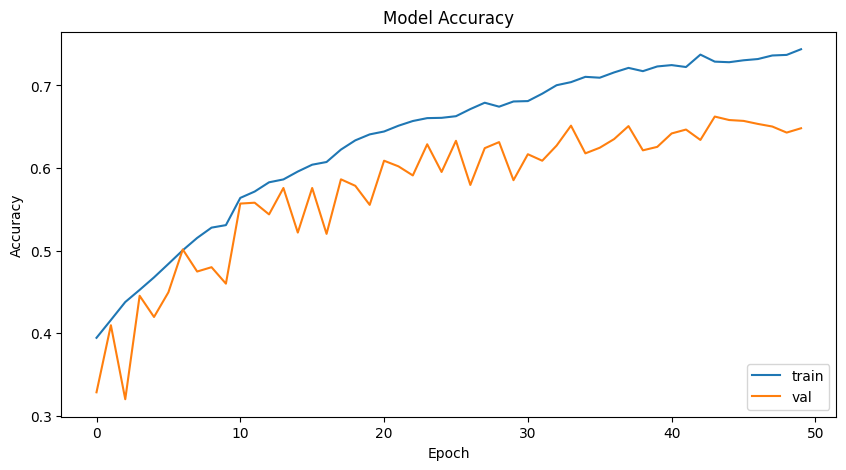

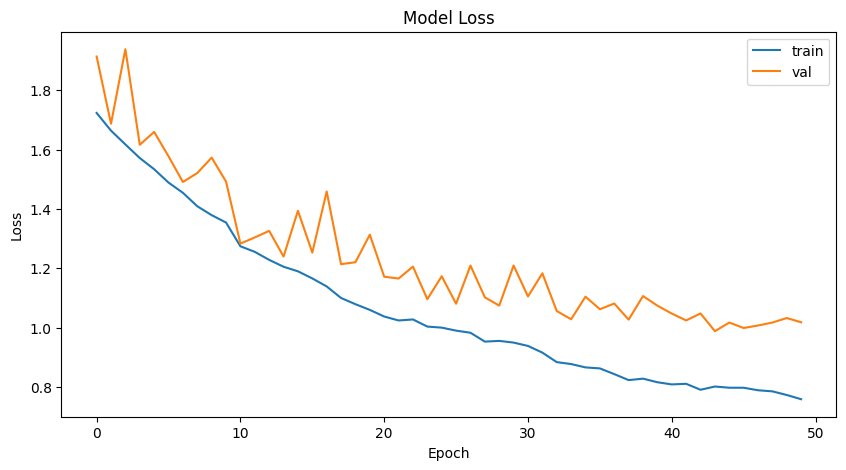

In [ ]:
plot_training_history(history)

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = []
y_pred = []

for x_batch, y_batch in val_ds:
    preds = model.predict(x_batch)
    y_pred.append(np.argmax(preds, axis=1)[0])
    y_true.append(np.argmax(y_batch.numpy(), axis=1)[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━

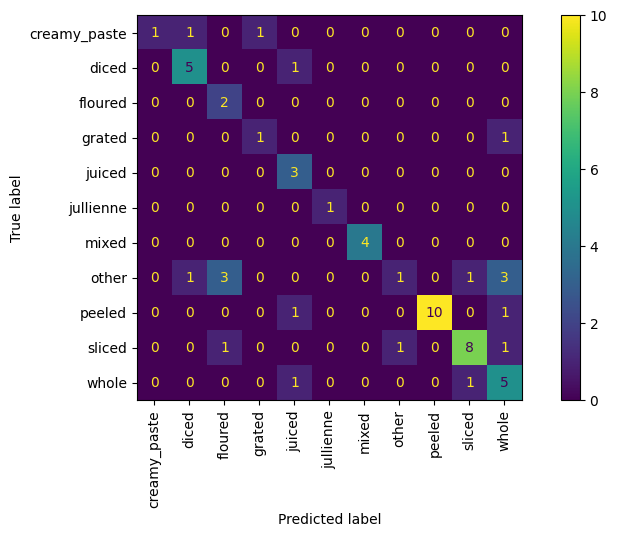

In [ ]:
cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm, display_labels=class_names).plot(xticks_rotation='vertical')

In [ ]:
pred_labels = model.predict(val_ds)

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  val_dir,
  #image_size=(img_height, img_width),
  batch_size=batch_size,
 #shuffle=False
  )

## Test for prediction

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
import numpy as np

In [ ]:
#Define test directory
test_dir = 'test/'

In [ ]:
img_width = 299
img_height = 299

In [ ]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  val_dir,
  image_size=(img_height, img_width),
  batch_size=1, #Must use batch 1 for testing
  label_mode='categorical',
  #shuffle=False
  )

Found 1907 files belonging to 11 classes.


In [ ]:
class_labels = test_ds.class_names

In [ ]:
test_ds = prepare(test_ds)

In [ ]:
model = load_model('model_foon.keras')

In [ ]:
pred_probs = model.predict(val_ds, verbose=1)

# Convert to class indices
y_pred = np.argmax(pred_probs, axis=1)

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step


In [ ]:
score = model.evaluate(val_ds, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.6285 - loss: 1.0924
Test loss: 1.0184170007705688
Test accuracy: 0.6481384634971619


In [ ]:
y_true = []
y_pred = []

for x, y in test_ds:
    pred = model.predict(x, verbose=0)
    y_true.append(np.argmax(y.numpy(), axis=1)[0])
    y_pred.append(np.argmax(pred, axis=1)[0])

In [ ]:
print(classification_report(y_true, y_pred, target_names=class_labels))

              precision    recall  f1-score   support

creamy_paste       0.55      0.68      0.61       140
       diced       0.70      0.76      0.73       169
     floured       0.52      0.89      0.66       120
      grated       0.76      0.63      0.69       142
      juiced       0.75      0.75      0.75       168
   jullienne       0.77      0.47      0.58       124
       mixed       0.85      0.84      0.84       119
       other       0.46      0.29      0.36       173
      peeled       0.85      0.66      0.74       297
      sliced       0.61      0.61      0.61       259
       whole       0.47      0.64      0.54       196

    accuracy                           0.65      1907
   macro avg       0.66      0.66      0.65      1907
weighted avg       0.67      0.65      0.65      1907



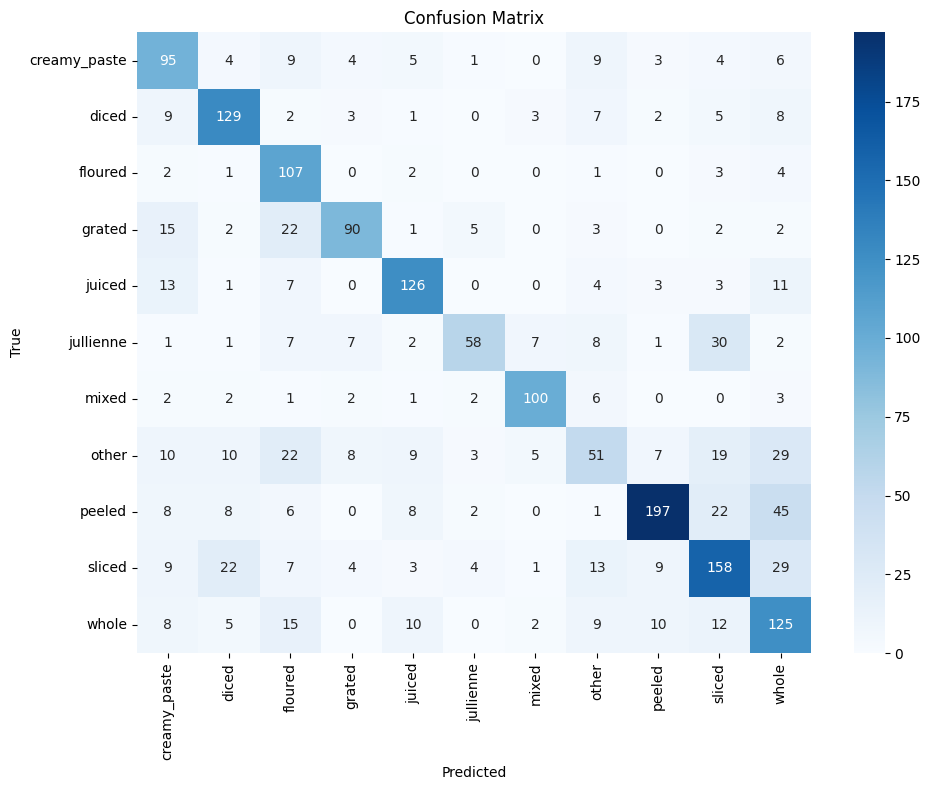

In [ ]:
# Confusion matrix -Training set
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

Predict Individual images

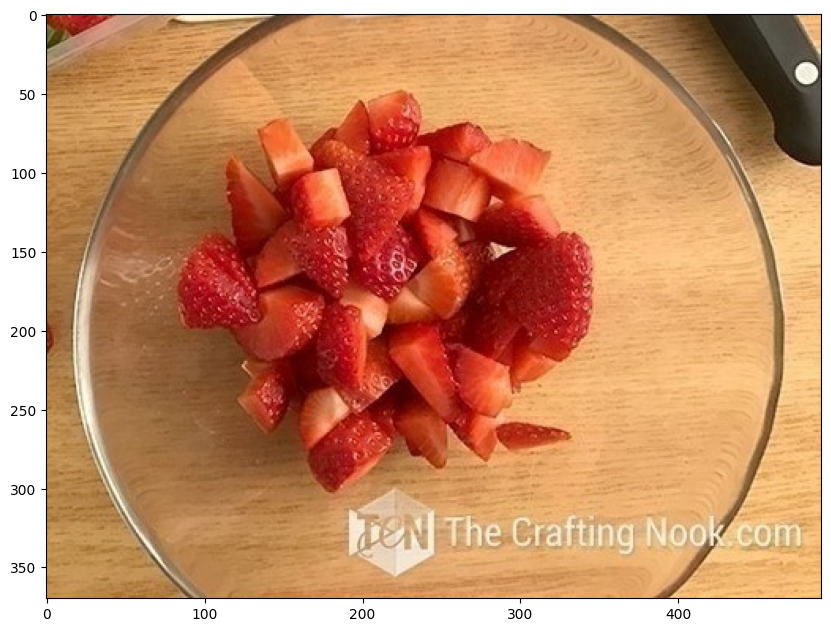

In [ ]:
#Select an image to test
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from matplotlib import pyplot as plt

#Test
img = load_img("./valid/diced/0001.jpg",
               color_mode='rgb',
               #target_size=(224,224)
              )


plt.imshow(img)

In [ ]:
#Convert the image to array
single_image = img_to_array(img)

#Also divide the image values by 255 to normalize
img_rank4 = np.expand_dims(single_image/255, axis=0)

model.predict(img_rank4)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


array([[0.09819856, 0.14733636, 0.00945595, 0.00448954, 0.03636853,
        0.01549684, 0.00139683, 0.35102436, 0.03698987, 0.15056905,
        0.14867412]], dtype=float32)

In [ ]:
np.round(model.predict(img_rank4),2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


array([[0.1 , 0.15, 0.01, 0.  , 0.04, 0.02, 0.  , 0.35, 0.04, 0.15, 0.15]],
      dtype=float32)

In [ ]:
# We can predict the class directly using the following function:

np.argmax(model.predict(img_rank4), axis=-1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


array([7])

In [1]:
# Retrieve the class labels from the train_generator:

label_map = (train_ds.class_indices)

label_map

In [2]:
list(label_map.keys())[np.argmax(model.predict(img_rank4), axis=-1)[0]]